In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space
from utils.utils import generate_video_with_text, create_scalarmappable, plot_scalebar, calculate_average_image, translate_images_to_mean_keypoint, subtract_average_image
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks, plot_colorline
from utils.piv_utils import plot_bbox

import pims

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

## two types of recordings 
1) 2024_0403_115306_025.MP4 - 60Hz?, 2:23 long, several captures, 80% prob. of ventral view
2) 2024_0403_115801_028.MP4 - 120Hz, two or three captures

Start with 120hz, but need another scale_video for mpp

In [8]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0403_115306_025.MP4"  
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename)
fps, num_frames, img_width, img_height = vid_props
print(vid_props)

results_save_path = f"./data/results/whirling/{vid_filename.split('.')[0]}/"
os.makedirs(results_save_path, exist_ok=True)

pixel_per_real_width = .61
mpp = 1.65  # microns_per_pixel
print("D high - FHD, pixel_per_real_width = ", pixel_per_real_width)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# export frames if necessary
EXPORT_FRAMES = False
export_frames = np.arange(0, num_frames, 1)
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), frames_filepaths, export_frames) if EXPORT_FRAMES else None


(60, 8596, 1920, 1080)
D high - FHD, pixel_per_real_width =  0.61


In [9]:
img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))  # before only used the green channel! now things look different in the locate function
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0403_115306_025/*.jpg
    Length: 8596 frames
    Frame Shape: (1080, 1920, 3)
    Pixel Datatype: uint8

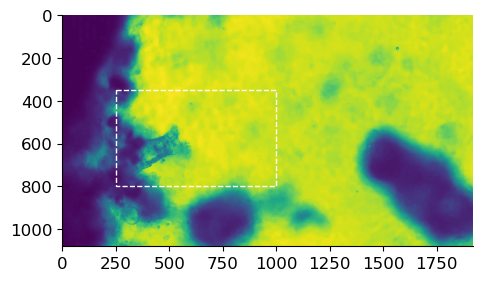

In [17]:
zoom_in = [250, 1000, 350, 800] 

plt.figure()
plt.imshow(frames[5000])
plot_bbox(zoom_in)

In [18]:
# Read-in
img_fp = sorted([os.path.join(frames_filepaths, f) for f in os.listdir(frames_filepaths) if f.endswith(".jpg")])
cut_width, cut_height = zoom_in[1] - zoom_in[0], zoom_in[3] - zoom_in[2]
text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
video_save_fpath = f"./data/results/whirling/{vid_filename.split('.')[0]}_focus-corona-zoom-text.mp4"
vid_params = dict(filename=video_save_fpath, 
                  fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                  fps=fps, 
                  frameSize=(cut_width, cut_height), 
                  isColor=True)

SAVE_VIDEO = True
generate_video_with_text(vid_params, img_fp, text_params, bbox=zoom_in) if SAVE_VIDEO else None

In [ ]:
from PIL import Image
zoom_in_pil = (150, 550, 1000, 900) # (left, upper, right, lower)

cut_frames = [[579,626], [4084,4137], [4689, 4727]]  # for food  capture
food_capture_dir = f"./data/images/{vid_filename.split('.')[0]}_food_capture_frames/"
os.makedirs(food_capture_dir, exist_ok=True)

SAVE_CUT = False
if SAVE_CUT:
    for cut in cut_frames:
        idx = np.arange(cut[0], cut[1])
        cut_imgs = [Image.open(img_fp[i]).crop(zoom_in_pil) for i in idx]
        des_fps = [os.path.join(food_capture_dir, os.path.basename(img_fp[i])) for i in idx]
        for img, des in zip(cut_imgs, des_fps):
            img.save(des)

In [ ]:
capture_frames = [[38,74], [405,468], [1033, 1088], [1299,1350],[1681,1725],[2149,2197],
                  [2708,2757],[3158,3211],[3792,3836],[4541,4591],[5628,5673],[5879,5916],
                  [6604,6644],[7145,7191],[7350,7390],[7605,7653]]  # left capture
# 405 might be rejected
# right capt: 1033, 1681, 3792,5879,6604,7145; 
# 2149**
#[5380,5438]
capture_reject_frames = [[],[],[]]